# Install and Load Packages

Modified from: https://towardsdatascience.com/how-to-explain-image-classifiers-using-lime-e364097335b4

In [3]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 8.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=32ce970550230de1a91836a4a1534a65657bdddcfd973cc2658f956ef237dcc0
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries

IMG_SIZE = (128, 128)

# Load Data

In [3]:
shutil.unpack_archive("/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/data-wikiart-emotion-dataset.zip", "/content/wikiart-emotion-dataset")
shutil.unpack_archive("/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/data-emotion-dataset.zip", "/content/image-emotion-dataset")


# Functions

In [10]:
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    # img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0

    # mean = np.mean(img, axis=(1,2), keepdims=True)
    # std = np.std(img, axis=(1,2), keepdims=True)
    # img = (img - mean) / std
    
    return img

LABELS = ['negative', 'other', 'positive']

def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {LABELS[model_prediction[0].argmax()]}")
    return LABELS[model_prediction.argmax()]

def generate_prediction_sample(exp, exp_class, weight = 0.0, show_positive = True, show_negative=False, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive,
                                         negative_only=show_negative,
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

# Load Model

In [7]:
MODEL_NAME = 'resnet50_512_256_3_earlystop_accuracy_layernormalization'
model = keras.models.load_model("/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/" + MODEL_NAME)

# Define Parameters

In [11]:
img_path = '/content/drive/MyDrive/Data Science - Master Notes/DL4CV Final Project/dl4cv final/negative/Copy of IMG_9162.jpg'

# Image

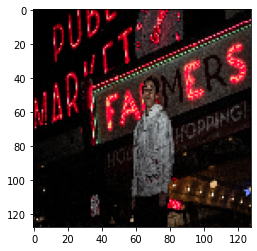

In [12]:
normalized_img = transform_image(img_path, IMG_SIZE)
plt.imshow(normalized_img[0]/255.)

# Image Predictions

In [13]:
model_prediction = model.predict(normalized_img)
model_prediction[0]

1/1 [==============================] - 2s 2s/step


array([7.6057249e-01, 1.4406429e-05, 2.3941313e-01], dtype=float32)

In [14]:
pred_orig = get_model_predictions(normalized_img)

1/1 [==============================] - 0s 96ms/step
The predicted class is : negative


# LIME

## Process

In [15]:
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(tf.cast(normalized_img[0], tf.float64).numpy(), 
                                 model.predict, 
                                 top_labels=1, 
                                 hide_color=0, 
                                 num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 510ms/step


## Img Segments

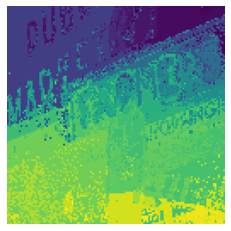

In [16]:
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

## Img Heatmap

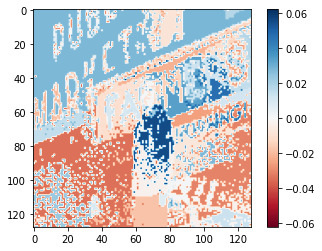

In [17]:
explanation_heatmap(exp, exp.top_labels[0])

# Slices

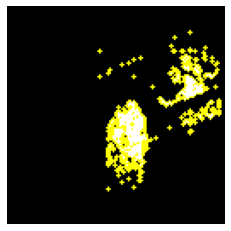

In [18]:
generate_prediction_sample(exp, exp.top_labels[0], hide_background = True)

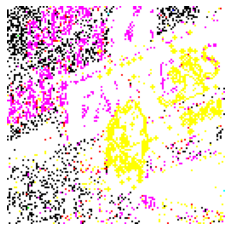

In [19]:
generate_prediction_sample(exp, exp.top_labels[0], hide_background = False)